## NS shop+ 홈쇼핑 매출 EDA
- 2019.01.01~2019.12.31 데이터
- 2020.06월 방송일시별 상품 매출 예측

### EDA를 위한 데이터 정제

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 한글 폰트 오류 해결
from matplotlib import font_manager, rc 
font_path = "C:\\Users\\이혜림\\Desktop\\Bita5/malgun.ttf" #폰트 파일의 위치
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc("font",family=font_name)

In [97]:
# 제공 데이터
data = pd.read_csv("./실적데이터.csv") # 내부데이터 (19.01.01~19.12.31) 판매실적 데이터
"""
판매군 -> 무형인 것은 취급액 0 -> 제외 필요
"""
tv = pd.read_csv("./시청률데이터.csv") # 외부데이터(19.01.01~19.12.31) 시청률 데이터
all_app = pd.read_csv("./ns홈쇼핑_app.csv") # 외부데이터(19.01.01~20.05) 어플 사용 데이터

# 평가데이터
submission = pd.read_csv("./평가데이터.csv") # 평가데이터 (2020.06) 판매실적 예측

In [98]:
# ~별 ~칼럼 확인
def calcul(df, by, on): 
    return df.groupby([by])[on].sum()/df.groupby([by])[on].count()

# str 형식 float 형식으로 변환
def to_float(df, column, f, t):
    df[column]=df[column].str.replace(f,t)
    df[column]=df[column].astype(float)

In [99]:
# 방송일시 datatime 형식으로 변환
data["방송일시"]=pd.to_datetime(data["방송일시"])

# 시간 및 요일 feature 추가
data["날짜"]=data["방송일시"].dt.date # 날짜
data["시간"]=data["방송일시"].dt.time # 시,분,초
data["요일"]=data["방송일시"].dt.dayofweek # 요일
data["시"]=data["방송일시"].dt.hour # 시
weekday = {"월":0,"화":1,"수":2,"목":3,"금":4,"토":5,"일":6} # 요일 칼럼 metadata

# 취급액 칼럼의 공백 제거
data.rename({" 취급액 ":"취급액"}, inplace=True, axis=1)

# 취급액, 판매단가 칼럼 int 형식으로 변환
data["취급액"]=data["취급액"].str.replace(",","")
data["판매단가"]=data["판매단가"].str.replace(",","")
data["판매단가"]=data["판매단가"].str.replace(" - ","0")
data["판매단가"]=data["판매단가"].astype(int)
data["취급액"].fillna(0, inplace=True) # NaN 값 0으로 대체
data["취급액"]=data["취급액"].astype(int)

# 주문량 칼럼 추가
data["주문량"]=data["취급액"]/data["판매단가"]

In [100]:
# 어플 사용 데이터
all_app.rename({"End +L10:AA21Date":"Date"}, inplace=True, axis=1) # 칼럼 이름 변화
all_app["Date"]=pd.to_datetime(all_app["Date"]) # datetime 형식으로 변환
all_app["Month"]=all_app["Date"].dt.month

# 년도별로 데이터 나눔
app_2019=all_app[838:1204] # 2019년
app_2020=all_app[1203:]

### 공휴일 feature 추가 및 상관계수
= 휴일에 따라 feature의 영향들이 다를 것 -> 실제로 시를 기준으로 해보았을 때 달랐음.

In [102]:
# 공휴일
holiday = ["2019-01-01","2019-02-04","2019-02-05","2019-02-06","2019-03-01","2019-05-05","2019-05-06","2019-05-12",
"2019-06-06","2019-08-15","2019-09-12","2019-09-13","2019-09-14","2019-10-03","2019-10-09","2019-12-25","2020-01-01"]
one = np.ones(17)
holiday = pd.DataFrame([holiday,one]).T
holiday.columns = ["날짜","holiday"]

In [103]:
# 공휴일 (대체 공휴일 포함, 공휴일이면서 주말인 것도 포함)
data["날짜"]=data["날짜"].astype(str) # merge를 위해 data의 날짜 칼럼을 str 형식으로 변환
data = data.merge(holiday,on=["날짜"],how="outer")
data.fillna(0,inplace=True) # 공휴일이 아닌 날은 0으로 채움

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,날짜,시간,요일,시,주문량,holiday
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000,2019-01-01,06:00:00,1,6,52.606516,1.0
1,2019-01-01 06:00:00,0.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000,2019-01-01,06:00:00,1,6,109.548872,1.0
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000,2019-01-01,06:20:00,1,6,81.754386,1.0
3,2019-01-01 06:20:00,0.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000,2019-01-01,06:20:00,1,6,174.310777,1.0
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000,2019-01-01,06:40:00,1,6,167.218045,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38304,2020-01-01 00:20:00,20.0,100073,200196,삼성화재 행복한파트너 주택화재보험(1912),무형,0,0,2020-01-01,00:20:00,2,0,0.000000,1.0
38305,2020-01-01 00:40:00,20.0,100073,200196,삼성화재 행복한파트너 주택화재보험(1912),무형,0,0,2020-01-01,00:40:00,2,0,0.000000,1.0
38306,2020-01-01 01:00:00,20.0,100073,200196,삼성화재 행복한파트너 주택화재보험(1912),무형,0,0,2020-01-01,01:00:00,2,1,0.000000,1.0
38307,2020-01-01 01:20:00,20.0,100490,201478,더케이 예다함 상조서비스(티포트),무형,0,0,2020-01-01,01:20:00,2,1,0.000000,1.0


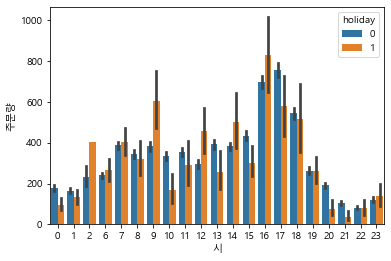

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\relational.py:823: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\relational.py:834: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\relational.py:823: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\relational.py:834: MatplotlibDeprecationWarning: Saw k

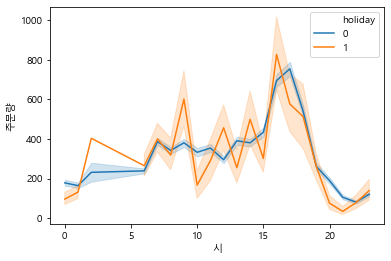

In [111]:
# 시각화
# 시각화를 위한 데이터 변환
data["holiday"]=data["holiday"].astype(int)
data["holiday"]=data["holiday"].astype(str)

sns.barplot(x="시",y="주문량",hue="holiday",data=data)
plt.show()
sns.lineplot(x="시",y="주문량",hue="holiday",data=data, c=["red","green"])
# 휴일에 따라 시별 peak time 다름